In [1]:
import numpy as np
import scipy
import pandas as pd
import sklearn.cluster
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x = np.load("gmm_data.npy")

## 初期化

In [3]:
kmeans = sklearn.cluster.KMeans(n_clusters=2, n_init="auto").fit(x[:, np.newaxis])
df = pd.DataFrame(dict(x=x, labels=kmeans.labels_))
display(df)

,x,labels
0,1.145809,0
1,-0.102975,1
2,1.852026,0
3,-2.041438,1
4,-0.411572,1
...,...,...
9995,-0.979454,1
9996,1.433581,0
9997,1.648436,0
9998,-0.827918,1


In [4]:
groupby = df.groupby("labels")
eta0 = (groupby.size() / len(x)).squeeze().to_numpy()
mu0 = groupby.mean().squeeze().to_numpy()
sigma0 = groupby.var(ddof=0).squeeze().to_numpy()
display(pd.DataFrame(dict(eta0=eta0, mu0=mu0, sigma0=sigma0)))

,eta0,mu0,sigma0
0,0.6105,0.989136,0.238518
1,0.3895,-1.060503,0.306956


## EMアルゴリズム

In [5]:
def e_step(x, eta, mu, sigma):
    log_resp = np.log(eta) + scipy.stats.norm.logpdf(x[:, np.newaxis], loc=mu, scale=sigma)
    log_resp -= scipy.special.logsumexp(log_resp, axis=-1, keepdims=True)
    return log_resp

In [6]:
def optimize_eta(N):
    return N / N.sum()
def optimize_mu(x, resp, N):
    return np.einsum("nk,n->k", resp, x) / N
def optimize_sigma(diff, resp, N):
    return np.sqrt(np.einsum("nk,nk,nk->k", resp, diff, diff) / N)

def m_step(x, log_resp):
    resp = np.exp(log_resp)
    N = resp.sum(axis=0)
    eta_ = optimize_eta(N)
    mu_ = optimize_mu(x, resp, N)
    sigma_ = optimize_sigma(x[:, np.newaxis] - mu_, resp, N)
    return (eta_, mu_, sigma_)

In [7]:
def log_likelihood(x, eta, mu, sigma):
    log_p = np.log(eta) + scipy.stats.norm.logpdf(x[:, np.newaxis], loc=mu, scale=sigma)
    return scipy.special.logsumexp(log_p, axis=-1).sum()

### 収束の様子を確認

In [8]:
eta = eta0
mu = mu0
sigma = sigma0

history = [log_likelihood(x, eta, mu, sigma)]
for _ in range(10):
    log_resp = e_step(x, eta, mu, sigma)
    (eta, mu, sigma) = m_step(x, log_resp)
    L = log_likelihood(x, eta, mu, sigma)
    history.append(L)

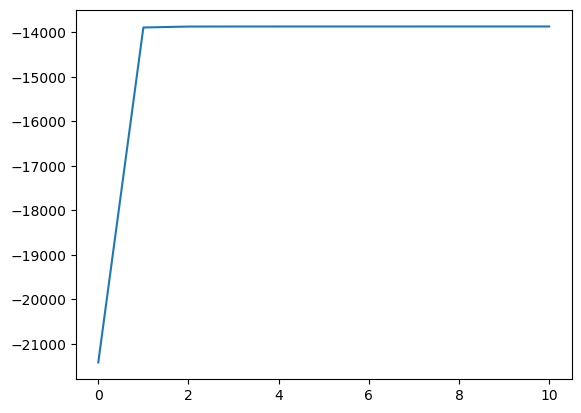

In [9]:
(fig, ax) = plt.subplots()
ax.plot(history)
plt.show()

### モデルを同定

In [10]:
MAX_ITER = 100
CONVERGENCE_THRESHOLD = 1e-3

def identify_gmm(x, eta0, mu0, sigma0):
    eta = eta0
    mu = mu0
    sigma = sigma0
    
    L = log_likelihood(x, eta, mu, sigma)
    for _ in range(MAX_ITER):
        log_resp = e_step(x, eta, mu, sigma)
        (eta, mu, sigma) = m_step(x, log_resp)
        L_ = log_likelihood(x, eta, mu, sigma)
        if abs(L_ - L) < CONVERGENCE_THRESHOLD:
            break
        L = L_
    
    return (eta, mu, sigma)

In [11]:
(eta, mu, sigma) = identify_gmm(x, eta0, mu0, sigma0)
display(pd.DataFrame(dict(eta=eta, mu=mu, sigma=sigma)))

,eta,mu,sigma
0,0.60401,0.988090,0.502192
1,0.39599,-1.025316,0.599266
